In [1]:
import torch
import os
import torchvision
from torchvision.transforms import v2
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torch.nn as nn
from PIL import Image, ImageOps
import torch
import pdb
import numpy as np
import yaml
from tqdm import tqdm
import sys
import matplotlib.pyplot as plt
sys.path.append('..')
from template import utils
from torchvision.utils import save_image

import torch.nn.functional as F

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# setting config
config = yaml.safe_load(open("config.yaml"))
batch_size = int(config["BATCH_SIZE"])

print(f"Our config: {config}")

Our config: {'BATCH_SIZE': 64, 'NUM_EPOCHS': 10, 'LR': '3e-4'}


In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    v2.Resize((128, 128))
])

In [5]:
train_dataset = torchvision.datasets.CelebA(root='./data', split='train',
                                        download=True, transform=transform)
valid_dataset = torchvision.datasets.CelebA(root='./data', split='valid',
                                       download=True, transform=transform)
test_dataset = torchvision.datasets.CelebA(root='./data', split='test',
                                       download=True, transform=transform)

#create dataloaders
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)
validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


# Display images from the dataset

In [ ]:
imgs, labels = next(iter(testloader))
print(f"Image Shapes: {imgs.shape}")
print(f"Label Shapes: {labels.shape}")

/home/user/lschulze/anaconda3/envs/lab/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


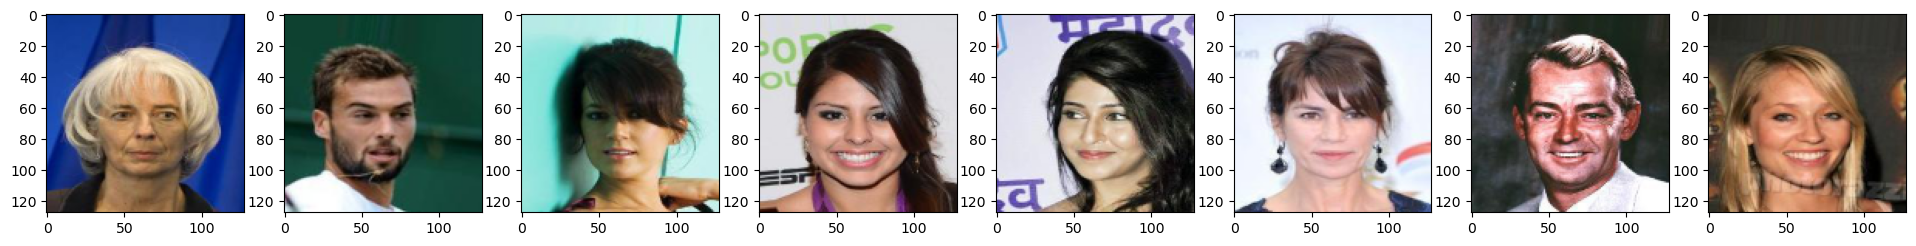

In [7]:
N_IMGS = 8
fig, ax = plt.subplots(1,N_IMGS)
fig.set_size_inches(3 * N_IMGS, 3)

ids = np.random.randint(low=0, high=len(train_dataset), size=N_IMGS)

for i, n in enumerate(ids):
    img = train_dataset[n][0].numpy().reshape(3,128,128).transpose(1, 2, 0)
    ax[i].imshow(img)
    #ax[i].set_title(f"Img #{n}  Label: {train_dataset[n][1]}")
    #ax[i].axis("off")
plt.show()

In [6]:
def save_model(model, optimizer, epoch, stats, exp_no = 40120241):
    """ Saving model checkpoint """
    
    if(not os.path.exists("experiments/experiment_"+str(exp_no)+"/models")):
        os.makedirs("experiments/experiment_"+str(exp_no)+"/models")
    savepath = "experiments/experiment_"+str(exp_no)+f"/models/checkpoint_epoch_{epoch}.pth"

    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'stats': stats
    }, savepath)
    
    return


def load_model(model, optimizer, savepath):
    """ Loading pretrained checkpoint """
    
    checkpoint = torch.load(savepath)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint["epoch"]
    stats = checkpoint["stats"]
    
    return model, optimizer, epoch, stats

In [7]:
def train_epoch(model, train_loader, optimizer, criterion, epoch, device, lambda_kld = 1e-03):
    """ Training a model for one epoch """
    
    loss_list = []
    recons_loss = []
    vae_loss = []
    
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader))
    for i, (images, _) in progress_bar:
        images = images.to(device)
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
         
        # Forward pass
        recons, (z, mu, log_var) = model(images)
         
        # Calculate Loss
        loss, (mse, kld) = criterion(recons, images, mu, log_var, lambda_kld)
        loss_list.append(loss.item())
        recons_loss.append(mse.item())
        vae_loss.append(kld.item())
        
        # Getting gradients w.r.t. parameters
        loss.backward()
         
        # Updating parameters
        optimizer.step()
        
        progress_bar.set_description(f"Epoch {epoch+1} Iter {i+1}: loss {loss.item():.5f}. ")
        
    mean_loss = np.mean(loss_list)
    
    return mean_loss, loss_list


@torch.no_grad()
def eval_model(model, eval_loader, criterion, device, epoch=None, savefig=False, savepath="", writer=None, lambda_kld = 1e-03):
    """ Evaluating the model for either validation or test """
    loss_list = []
    recons_loss = []
    kld_loss = []
    
    for i, (images, _) in enumerate(eval_loader):
        images = images.to(device)
        
        # Forward pass 
        recons, (z, mu, log_var) = model(images)
                 
        loss, (mse, kld) = criterion(recons, images, mu, log_var, lambda_kld)
        loss_list.append(loss.item())
        recons_loss.append(mse.item())
        kld_loss.append(kld.item())
        
        if(i==0 and savefig):
            save_image(recons[:64].cpu(), os.path.join(savepath, f"recons{epoch}.png"))
            
    # Total correct predictions and loss
    loss = np.mean(loss_list)
    recons_loss = np.mean(recons_loss)
    kld_loss = np.mean(kld_loss)
    return loss, recons_loss, kld_loss


def train_model(model, optimizer, scheduler, criterion, train_loader, valid_loader,
                num_epochs, writer,savepath="", save_frequency=2,lambda_kld = 1e-03):
    """ Training a model for a given number of epochs"""
    
    train_loss = []
    val_loss =  []
    val_loss_recons =  []
    val_loss_kld =  []
    loss_iters = []
    
    for epoch in range(num_epochs):
           
        # validation epoch
        model.eval()  # important for dropout and batch norms
        log_epoch = (epoch % save_frequency == 0 or epoch == num_epochs - 1)
        loss, recons_loss, kld_loss = eval_model(
                model=model, eval_loader=valid_loader, criterion=criterion,
                device=device, epoch=epoch, savefig=log_epoch, savepath=savepath,
                writer=writer, lambda_kld = lambda_kld
            )
        val_loss.append(loss)
        val_loss_recons.append(recons_loss)
        val_loss_kld.append(kld_loss)

        
        # training epoch
        model.train()  # important for dropout and batch norms
        mean_loss, cur_loss_iters = train_epoch(
                model=model, train_loader=train_loader, optimizer=optimizer,
                criterion=criterion, epoch=epoch, device=device, lambda_kld = lambda_kld 
            )
        
        # PLATEAU SCHEDULER
        scheduler.step(val_loss[-1])
        train_loss.append(mean_loss)
        loss_iters = loss_iters + cur_loss_iters
        
        if(epoch % save_frequency == 0):
            stats = {
                "train_loss": train_loss,
                "valid_loss": val_loss,
                "loss_iters": loss_iters
            }
            save_model(model=model, optimizer=optimizer, epoch=epoch, stats=stats)
        
        if(log_epoch):
            print(f"    Train loss: {round(mean_loss, 5)}")
            print(f"    Valid loss: {round(loss, 5)}")
            print(f"       Valid loss recons: {round(val_loss_recons[-1], 5)}")
            print(f"       Valid loss KL-D:   {round(val_loss_kld[-1], 5)}")
    
    print(f"Training completed")
    return train_loss, val_loss, loss_iters, val_loss_recons, val_loss_kld

Dropouts + additional conv layers led to brwon pictures, but more details -> did not improve. When only using kernel size = 2 we saw very blocky pictures so we opted for kernel size 3 with a smaller stride. The results were as expected. We lost some of the blockieness. Increasing encoder linear layers did not help   (led to brownness)
After fixing this with additional conv operations ath the end, we still had the problem that the vae was overfitting to much to the input vectors. Dropout led to brownish images again, which why this was not a viable choice. Future work should experiment more with the exact placing of the dropouts. 

In [11]:
class ConvVAE(nn.Module):
    
    def __init__(self):
        super(ConvVAE, self).__init__()

        # Define Convolutional Encoders
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels = 8, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2),
            nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2),
            nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2),
            nn.Flatten(),
        )

        # Define mean and variance
        self.mu = nn.Linear(8192, 200)
        
        # Note: we learn the log variance to make training easier (allows negative values)
        self.log_var = nn.Linear(8192, 200)

        # Define decoder
        self.decoder = nn.Sequential(
            nn.Linear(200, 8192),
            nn.ReLU(),
            nn.Unflatten(dim = 1, unflattened_size=(32, 16, 16)),
            nn.ConvTranspose2d(in_channels = 32, out_channels=32, kernel_size = 3, stride = 2, padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=32, out_channels = 16, kernel_size = 3, stride = 2, padding = 0),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels = 16, out_channels = 16, kernel_size = 3, stride = 2, padding = 0),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=8, stride = 1, padding = 0),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=3, kernel_size=3, stride = 1, padding = 1),
        )

    def reparameterize(self, mu, log_var):
        """ Reparametrization trick"""
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)  # random sampling happens here
        z = mu + std * eps
        return z

    def forward(self, x):
        x = self.encoder(x)
        mean = self.mu(x)
        log_var = self.log_var(x)

        z = self.reparameterize(mean, log_var)
        x_hat = self.decoder(z)
        return x_hat, (z, mean, log_var)

In [12]:
def vae_loss_function(recons, target, mu, log_var, lambda_kld=1e-3):
    """
    Combined loss function for joint optimization of 
    reconstruction and ELBO
    """
    recons_loss = F.mse_loss(recons, target)
    # Deriving kld for vaes: https://stats.stackexchange.com/questions/318748/deriving-the-kl-divergence-loss-for-vaes
    kld = (-0.5 * (1 + log_var - mu**2 - log_var.exp()).sum(dim=1)).mean(dim=0)  # closed-form solution of KLD in Gaussian
    loss = recons_loss + lambda_kld * kld

    return loss, (recons_loss, kld)

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
cvae = ConvVAE()
criterion = vae_loss_function
optimizer = torch.optim.Adam(cvae.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience = 3, factor = 0.5, verbose = True)
cvae = cvae.to(device)

In [12]:
savepath = "/home/user/lschulze/projects/CudaVisionWS23/Assignment5/experiments/experiment_9"


In [13]:
'''train_loss, val_loss, loss_iters, val_loss_recons, val_loss_kld = train_model(
        model=cvae, optimizer=optimizer, scheduler=scheduler, criterion=vae_loss_function,
        train_loader=trainloader, valid_loader=validloader, num_epochs=15, savepath=savepath, writer=None)'''

'train_loss, val_loss, loss_iters, val_loss_recons, val_loss_kld = train_model(\n        model=cvae, optimizer=optimizer, scheduler=scheduler, criterion=vae_loss_function,\n        train_loader=trainloader, valid_loader=validloader, num_epochs=15, savepath=savepath, writer=None)'

In [14]:
cvae = ConvVAE().to(device)
cvae, optimizer, epoch, stats = load_model(cvae, optimizer, '/home/user/lschulze/projects/CudaVisionWS23/Assignment5/experiments/experiment_6/models/checkpoint_epoch_74.pth')

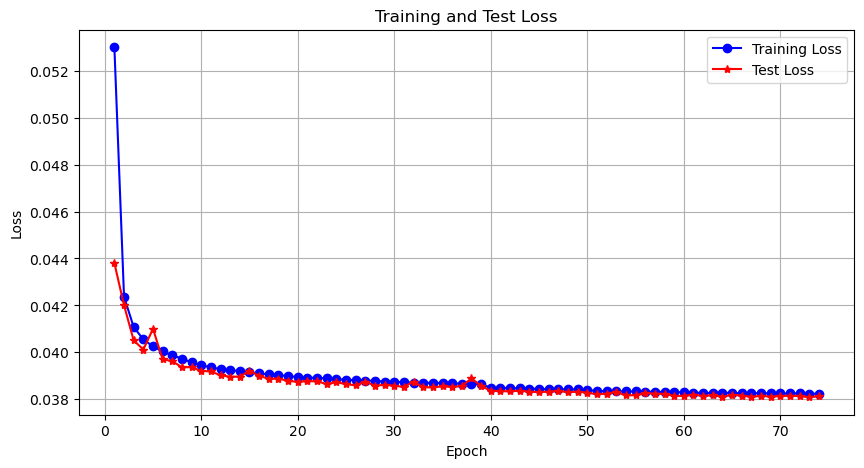

In [15]:
utils.plot_loss_epoch(stats['train_loss'][:74], stats['valid_loss'][1:])

We observe that most of our training loss decrease occurs after the first epoch. After that we continue to see marginal improvements in our losses. This makes sense when viewing the reconstruction pictures, considering they get increasingly detailed as we continue training.

In [16]:
# Generate more images
with torch.no_grad():
    for i in range(5):
        z = torch.randn(64, 200).to(device)
        sample = cvae.decoder(z)
    

recons = sample.view(64, 3, 128, 128).cpu()


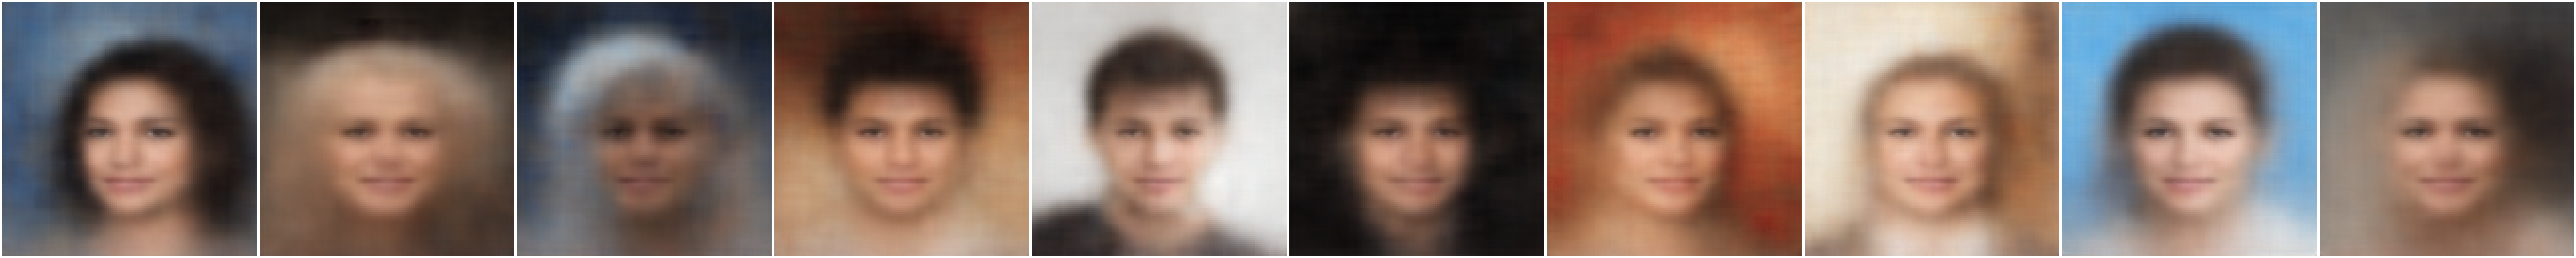

In [17]:
fig, axes = plt.subplots(1, 10, figsize=(128, 128))  # Adjust figsize as needed

for i in range(10):
    img = recons[i].numpy().reshape(3, 128, 128).transpose(1, 2, 0)
    axes[i].imshow(img)
    axes[i].axis('off')  # Turn off axis labels for clarity

plt.tight_layout()
plt.show()

In [18]:
test_data, labels = next(iter(testloader))
test_data = test_data.to(device)

with torch.no_grad():
    sample, _ = cvae(test_data)

    recons = sample.view(batch_size, 3, 128, 128).cpu()

    fig, axes = plt.subplots(2, 10, figsize=(128, 128))  # Adjust figsize as needed

    for i in range(10):
        img = recons[i].numpy().reshape(3, 128, 128).transpose(1, 2, 0)
        # test_img = test_data[i].reshape(3, 128, 128).transpose(1, 2, 0)
        test_img = test_data[i].cpu().numpy().reshape(3,128,128).transpose(1, 2, 0)
        axes[0][i].imshow(test_img)
        axes[0][i].axis('off')
        axes[1][i].imshow(img)
        axes[1][i].axis('off')  # Turn off axis labels for clarity

    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


## Implement a ConvVAE using a pretrained encoder (e.g. ResNet18, ConvNeXt-Tiny, ...)

First we implement Resnet Decoder that is more or less a mirrored version of the resnet 18 pretrained encoder

In [13]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=2, transpose=False):
        super(BasicBlock, self).__init__()
        self.transpose = transpose
        output_padding = 1 if stride > 1 else 0
        self.conv1 = nn.ConvTranspose2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, \
                                        output_padding=output_padding, bias=False)
        self.conv2 = nn.ConvTranspose2d(planes, planes, kernel_size=3, stride=1, padding=1, \
                                        output_padding=0, bias=False)

        self.bn1 = nn.BatchNorm2d(planes)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.ConvTranspose2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, output_padding=output_padding, bias=False),
              #  nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x))) #self.bn1()
        out = self.bn2(self.conv2(out)) #self.bn2()
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class Decoder(nn.Module):
    def __init__(self, block, num_blocks, latent_dim):
        super(Decoder, self).__init__()
        self.in_planes = 64*block.expansion
        self.fc2 = nn.Linear(latent_dim, 4096)
        
        self.layer1 = self._make_layer(block, 32, num_blocks[3], stride=2, transpose=True) #filter numbers are decreased but architecture remains the same
        self.layer2 = self._make_layer(block, 16, num_blocks[2], stride=2, transpose=True)
        self.layer3 = self._make_layer(block, 8, num_blocks[1], stride=2, transpose=True)
        self.layer4 = self._make_layer(block, 8, num_blocks[0], stride= 1, transpose=True)
        self.conv1 = nn.ConvTranspose2d(8, 3, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(3)

    def _make_layer(self, block, planes, num_blocks, stride, transpose):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in reversed(strides):
            layers.append(block(self.in_planes, planes, stride, transpose))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.fc2(x))
        out = out.view(out.size(0),64,8,8)  # reshape output of linear layer
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.relu(self.bn1(self.conv1(out))) 
        return out

def DecoderResNet18(latent_dim):
    return Decoder(BasicBlock, [2,2,2,2], latent_dim)

In [14]:
class ResNetVAE(nn.Module):
    def __init__(self, latent_dim = 512):
        super(ResNetVAE, self).__init__()
        
        resnet = torchvision.models.resnet18(weights='DEFAULT')
        self.encoder = resnet
        
        # Note: 1000 marks the output dim of resnet
        self.mu = nn.Linear(1000, latent_dim)
        
        # Note: we learn the log variance to make training easier (allows negative values)
        self.log_var = nn.Linear(1000, latent_dim)
        
        # Decoder is re-used thanks to deleting last fc layer in the pretrained convnext encoder.
        self.decoder = DecoderResNet18(latent_dim)

        
    def reparameterize(self, mu, log_var):
        """ Reparametrization trick"""
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)  # random sampling happens here
        z = mu + std * eps
        return z

    def forward(self, x):
        x = self.encoder(x)
        mu = self.mu(x)
        log_var = self.log_var(x)
        z = self.reparameterize(mu, log_var)
        x_hat = self.decoder(z)
        return x_hat, (z, mu, log_var)

In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
resnetvae = ResNetVAE(512)
criterion = vae_loss_function
optimizer = torch.optim.Adam(resnetvae.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience = 4, factor = 0.5, verbose = True)
resnetvae = resnetvae.to(device)

In [16]:
num_epochs = 50

In [17]:
device

'cuda'

In [18]:
train_loss, val_loss, loss_iters, val_loss_recons, val_loss_kld = train_model(
        model=resnetvae, optimizer=optimizer, scheduler=scheduler, criterion=vae_loss_function,
        train_loader=trainloader, valid_loader=validloader, num_epochs=num_epochs, writer=None,lambda_kld=1e-4)

Epoch 1 Iter 2544: loss 0.03966. : 100%|█████████████████████████████████████████████████████████| 2544/2544 [02:39<00:00, 15.94it/s]


    Train loss: 0.07908
    Valid loss: 0.57485
       Valid loss recons: 0.28432
       Valid loss KL-D:   2905.30506


Epoch 3 Iter 2544: loss 0.02737. : 100%|█████████████████████████████████████████████████████████| 2544/2544 [01:44<00:00, 24.29it/s]


    Train loss: 0.02353
    Valid loss: 0.02543
       Valid loss recons: 0.0209
       Valid loss KL-D:   45.28074


Epoch 5 Iter 2544: loss 0.02303. : 100%|█████████████████████████████████████████████████████████| 2544/2544 [01:44<00:00, 24.45it/s]


    Train loss: 0.02179
    Valid loss: 0.02297
       Valid loss recons: 0.01813
       Valid loss KL-D:   48.41507


Epoch 7 Iter 2544: loss 0.02221. : 100%|█████████████████████████████████████████████████████████| 2544/2544 [01:44<00:00, 24.41it/s]


    Train loss: 0.02095
    Valid loss: 0.02095
       Valid loss recons: 0.01612
       Valid loss KL-D:   48.29697


Epoch 9 Iter 2544: loss 0.02239. : 100%|█████████████████████████████████████████████████████████| 2544/2544 [01:43<00:00, 24.49it/s]


    Train loss: 0.02037
    Valid loss: 0.0205
       Valid loss recons: 0.01553
       Valid loss KL-D:   49.74597


Epoch 11 Iter 2544: loss 0.01845. : 100%|████████████████████████████████████████████████████████| 2544/2544 [01:43<00:00, 24.49it/s]


    Train loss: 0.02
    Valid loss: 0.01985
       Valid loss recons: 0.01494
       Valid loss KL-D:   49.08961


Epoch 13 Iter 2544: loss 0.02589. : 100%|████████████████████████████████████████████████████████| 2544/2544 [01:43<00:00, 24.51it/s]


    Train loss: 0.02088
    Valid loss: 0.0196
       Valid loss recons: 0.01457
       Valid loss KL-D:   50.2956


Epoch 15 Iter 2544: loss 0.02095. : 100%|████████████████████████████████████████████████████████| 2544/2544 [01:44<00:00, 24.46it/s]


    Train loss: 0.01976
    Valid loss: 0.01961
       Valid loss recons: 0.01432
       Valid loss KL-D:   52.85515


Epoch 17 Iter 2544: loss 0.02059. : 100%|████████████████████████████████████████████████████████| 2544/2544 [01:44<00:00, 24.45it/s]


    Train loss: 0.01954
    Valid loss: 0.01948
       Valid loss recons: 0.01435
       Valid loss KL-D:   51.30299


Epoch 19 Iter 2544: loss 0.02018. : 100%|████████████████████████████████████████████████████████| 2544/2544 [01:43<00:00, 24.51it/s]


    Train loss: 0.01958
    Valid loss: 0.01942
       Valid loss recons: 0.01421
       Valid loss KL-D:   52.10604


Epoch 21 Iter 2544: loss 0.02264. : 100%|████████████████████████████████████████████████████████| 2544/2544 [01:44<00:00, 24.40it/s]


    Train loss: 0.01934
    Valid loss: 0.01925
       Valid loss recons: 0.01401
       Valid loss KL-D:   52.39189


Epoch 23 Iter 2544: loss 0.01886. : 100%|████████████████████████████████████████████████████████| 2544/2544 [01:44<00:00, 24.45it/s]


    Train loss: 0.01924
    Valid loss: 0.01923
       Valid loss recons: 0.01397
       Valid loss KL-D:   52.6373


Epoch 25 Iter 2544: loss 0.01988. : 100%|████████████████████████████████████████████████████████| 2544/2544 [01:43<00:00, 24.48it/s]


    Train loss: 0.01916
    Valid loss: 0.01934
       Valid loss recons: 0.01399
       Valid loss KL-D:   53.5481


Epoch 27 Iter 2544: loss 0.02156. : 100%|████████████████████████████████████████████████████████| 2544/2544 [01:44<00:00, 24.27it/s]


    Train loss: 0.01908
    Valid loss: 0.019
       Valid loss recons: 0.01366
       Valid loss KL-D:   53.37492


Epoch 29 Iter 2544: loss 0.02175. : 100%|████████████████████████████████████████████████████████| 2544/2544 [01:44<00:00, 24.45it/s]


    Train loss: 0.01902
    Valid loss: 0.01911
       Valid loss recons: 0.01375
       Valid loss KL-D:   53.59315


Epoch 31 Iter 2544: loss 0.02035. : 100%|████████████████████████████████████████████████████████| 2544/2544 [01:43<00:00, 24.51it/s]


    Train loss: 0.01897
    Valid loss: 0.01894
       Valid loss recons: 0.01351
       Valid loss KL-D:   54.28299


Epoch 33 Iter 2544: loss 0.02093. : 100%|████████████████████████████████████████████████████████| 2544/2544 [01:44<00:00, 24.45it/s]


    Train loss: 0.01891
    Valid loss: 0.01885
       Valid loss recons: 0.01343
       Valid loss KL-D:   54.13779


Epoch 35 Iter 2544: loss 0.02034. : 100%|████████████████████████████████████████████████████████| 2544/2544 [01:44<00:00, 24.37it/s]


    Train loss: 0.01885
    Valid loss: 0.01887
       Valid loss recons: 0.01341
       Valid loss KL-D:   54.5866


Epoch 37 Iter 2544: loss 0.01945. : 100%|████████████████████████████████████████████████████████| 2544/2544 [01:44<00:00, 24.46it/s]


    Train loss: 0.01881
    Valid loss: 0.01879
       Valid loss recons: 0.0135
       Valid loss KL-D:   52.97335


Epoch 39 Iter 2544: loss 0.01797. : 100%|████████████████████████████████████████████████████████| 2544/2544 [01:43<00:00, 24.46it/s]


    Train loss: 0.01878
    Valid loss: 0.01879
       Valid loss recons: 0.0134
       Valid loss KL-D:   53.91221


Epoch 41 Iter 2544: loss 0.01838. : 100%|████████████████████████████████████████████████████████| 2544/2544 [01:44<00:00, 24.28it/s]


    Train loss: 0.01874
    Valid loss: 0.01876
       Valid loss recons: 0.01336
       Valid loss KL-D:   54.01153


Epoch 43 Iter 2544: loss 0.01922. : 100%|████████████████████████████████████████████████████████| 2544/2544 [01:44<00:00, 24.24it/s]


    Train loss: 0.01885
    Valid loss: 0.01864
       Valid loss recons: 0.01319
       Valid loss KL-D:   54.45878


Epoch 45 Iter 2544: loss 0.01930. : 100%|████████████████████████████████████████████████████████| 2544/2544 [01:44<00:00, 24.45it/s]


    Train loss: 0.01869
    Valid loss: 0.01871
       Valid loss recons: 0.01325
       Valid loss KL-D:   54.59709


Epoch 47 Iter 2544: loss 0.01874. : 100%|████████████████████████████████████████████████████████| 2544/2544 [01:44<00:00, 24.45it/s]


    Train loss: 0.01868
    Valid loss: 0.01912
       Valid loss recons: 0.01363
       Valid loss KL-D:   54.88449


Epoch 49 Iter 2544: loss 0.01891. : 100%|████████████████████████████████████████████████████████| 2544/2544 [01:46<00:00, 23.86it/s]


Epoch 00049: reducing learning rate of group 0 to 5.0000e-04.
    Train loss: 0.01864
    Valid loss: 0.01892
       Valid loss recons: 0.01329
       Valid loss KL-D:   56.22169


Epoch 50 Iter 2544: loss 0.02033. : 100%|████████████████████████████████████████████████████████| 2544/2544 [08:38<00:00,  4.91it/s]

    Train loss: 0.01845
    Valid loss: 0.01856
       Valid loss recons: 0.01306
       Valid loss KL-D:   54.98609
Training completed


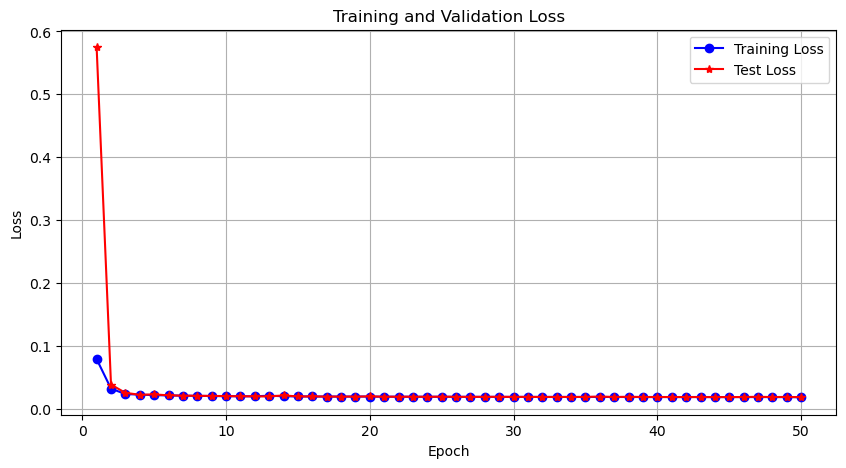

In [20]:
utils.plot_loss_epoch(train_loss, val_loss)

In [22]:
# Generate more images
with torch.no_grad():
    for i in range(5):
        z = torch.randn(64, 512).to(device)
        sample = resnetvae.decoder(z)
    

recons = sample.view(64, 3, 128, 128).cpu()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


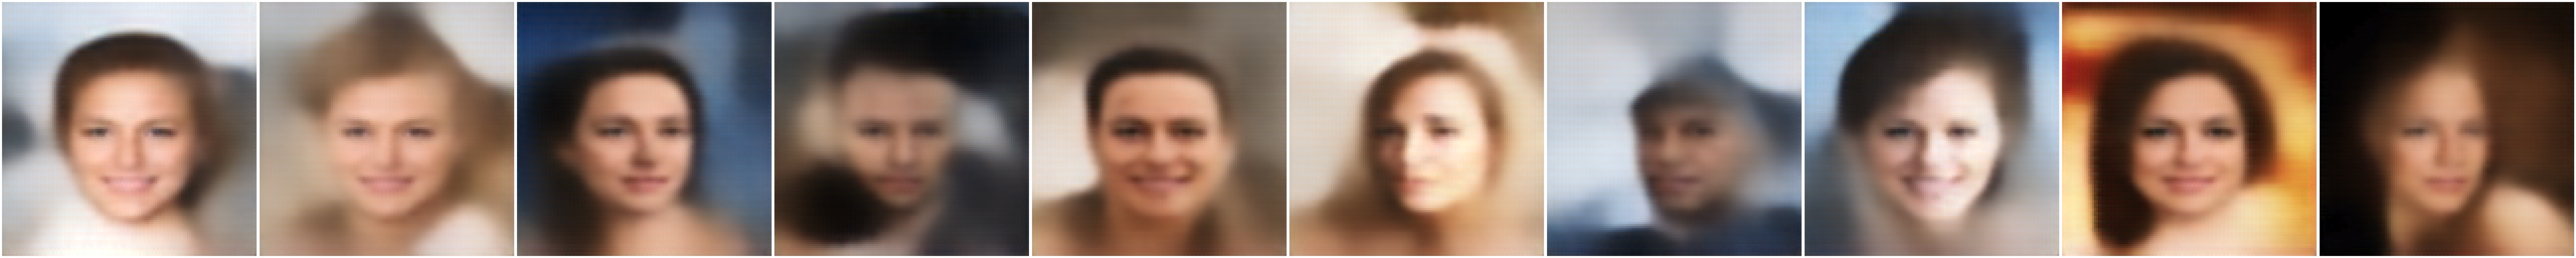

In [23]:
fig, axes = plt.subplots(1, 10, figsize=(128, 128))  # Adjust figsize as needed

for i in range(10):
    img = recons[i].numpy().reshape(3, 128, 128).transpose(1, 2, 0)
    axes[i].imshow(img)
    axes[i].axis('off')  # Turn off axis labels for clarity

plt.tight_layout()
plt.show()

In [24]:
test_data, labels = next(iter(testloader))
test_data = test_data.to(device)

with torch.no_grad():
    sample, _ = resnetvae(test_data)

    recons = sample.view(batch_size, 3, 128, 128).cpu()

    fig, axes = plt.subplots(2, 10, figsize=(128, 128))  # Adjust figsize as needed

    for i in range(10):
        img = recons[i].numpy().reshape(3, 128, 128).transpose(1, 2, 0)
        # test_img = test_data[i].reshape(3, 128, 128).transpose(1, 2, 0)
        test_img = test_data[i].cpu().numpy().reshape(3,128,128).transpose(1, 2, 0)
        axes[0][i].imshow(test_img)
        axes[0][i].axis('off')
        axes[1][i].imshow(img)
        axes[1][i].axis('off')  # Turn off axis labels for clarity

    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


# Frechet Inception Distance

We use the implementation of torchmetrics to calculate the frechet inception distance.


In [ ]:
import torchmetrics

## Frechet Inception Distance ConvVAE

In [ ]:
from torchmetrics.image.fid import FrechetInceptionDistance
fid = FrechetInceptionDistance(feature=64, normalize = True)
# Torchmetrics implementation does not use cuda for some reason
device = 'cpu'
cvae = cvae.to(device)

test_dataset = torchvision.datasets.CelebA(root='./data', split='test',
                                       download=True, transform=transform)

testloader = torch.utils.data.DataLoader(test_dataset, batch_size = 64)

progress_bar = tqdm(enumerate(testloader), total=len(testloader))
for i, (test_data, _) in progress_bar:
    test_data = test_data.to(device)
    z = torch.randn(64, 200).to(device)
    sample = cvae.decoder(z)
    fid.update(sample, real=False)
    fid.update(test_data, real=True)
fid.compute()

# Analysis of Latent Space: ConvVAE

In [13]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

In [14]:
imgs_flat, latents, labels = [], [], []
with torch.no_grad():
    for imgs, lbls in testloader:
        imgs = imgs.to(device)
        _, z, _, _ = cvae(imgs)
        imgs_flat.append(imgs.cpu().view(imgs.shape[0],-1))
        latents.append(z.cpu())
        labels.append(lbls)
        
imgs_flat = np.concatenate(imgs_flat)    
latents = np.concatenate(latents)
labels = np.concatenate(labels)

/home/user/lschulze/anaconda3/envs/lab/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/user/lschulze/anaconda3/envs/lab/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from No

In [15]:
COLORS = ['r', 'b', 'g', 'y', 'purple', 'orange', 'k', 'brown', 'grey',
          'c', "gold", "fuchsia", "lime", "darkred", "tomato", "navy"]

def display_projections(points, labels, ax=None, legend=None):
    """ Displaying low-dimensional data projections """
    
    legend = [f"Class {l}" for l in np.unique(labels)] if legend is None else legend
    if(ax is None):
        _, ax = plt.subplots(1,1,figsize=(12,6))
    
    for i,l in enumerate(np.unique(labels)):
        idx = np.where(l==labels)

        ax.scatter(points[idx, 0], points[idx, 1], label=legend[int(l)], c=COLORS[i])
    ax.legend(loc="best")

In [21]:
pca_imgs = PCA(n_components=2).fit_transform(imgs_flat)


torch.Size([19962, 1])

In [26]:
test_dataset.identity[0]

tensor([7760])

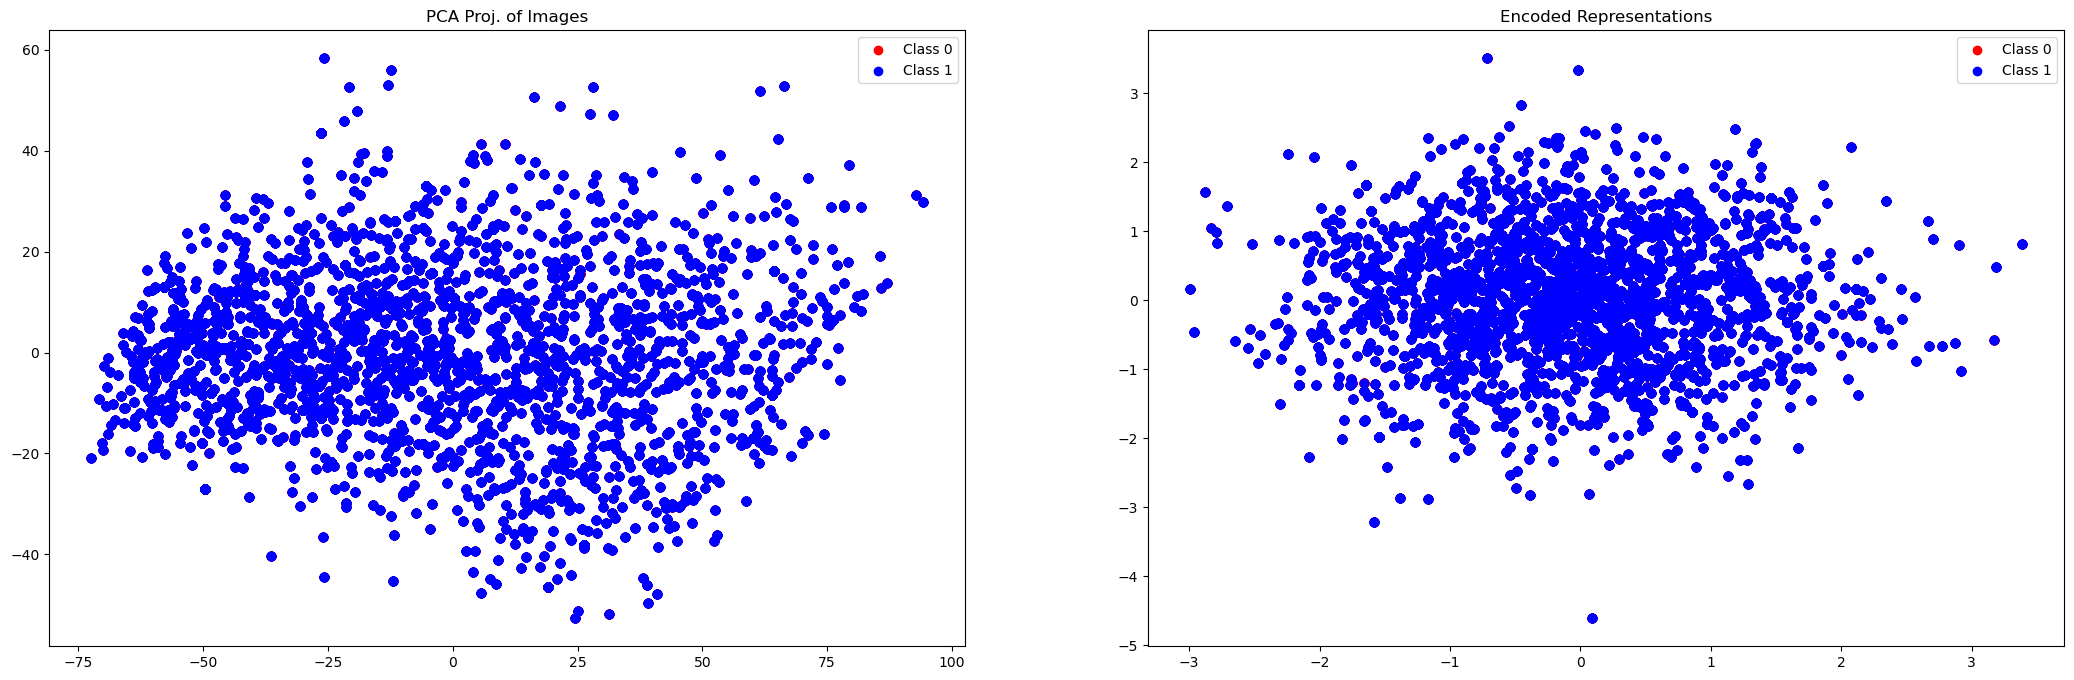

In [29]:

N = 2000
fig,ax = plt.subplots(1,2,figsize=(26,8))
display_projections(pca_imgs[:N ], labels[:N], ax=ax[0]) 
ax[0].set_title("PCA Proj. of Images")
display_projections(latents[:N], labels[:N], ax=ax[1])
ax[1].set_title("Encoded Representations")
plt.show()

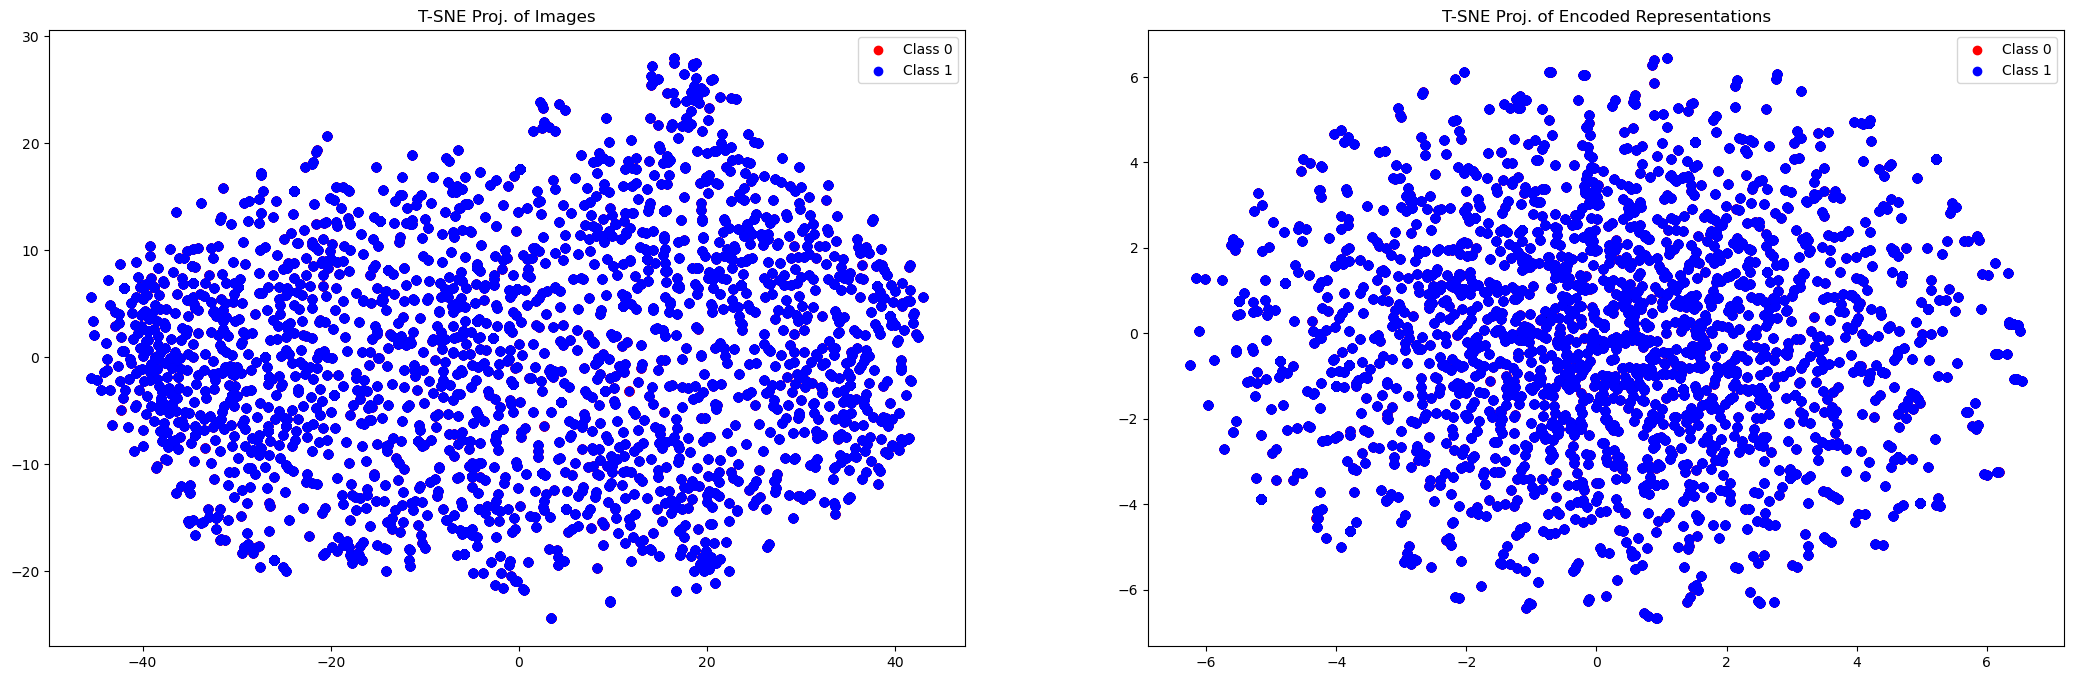

In [24]:
N = 2000
tsne_imgs = TSNE(n_components=2).fit_transform(imgs_flat[:N])
tsne_latents = TSNE(n_components=2).fit_transform(latents[:N])

fig,ax = plt.subplots(1,2,figsize=(26,8))
display_projections(tsne_imgs[:N], labels[:N], ax=ax[0])
ax[0].set_title("T-SNE Proj. of Images")
display_projections(tsne_latents[:N], labels[:N], ax=ax[1])
ax[1].set_title("T-SNE Proj. of Encoded Representations")
plt.show()

# Interpolation: ConvVAE

In [30]:
@torch.no_grad()
def plot_reconstructed(model, xrange=(-3, 3), yrange=(-2, 2), N=12):
    """
    Sampling equispaced points from the latent space givent the xange and yrange, 
    decoding latents and visualizing distribution of the space
    """
    SIZE = 32
    grid = np.empty((N*SIZE, N*SIZE))
    
    for i, y in enumerate(np.linspace(*yrange, N)):
        for j, x in enumerate(np.linspace(*xrange, N)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = model.decoder(z).cpu()
            x_hat = x_hat.view(32,32)
            
            grid[(N-1-i)*SIZE:(N-i)*SIZE, j*SIZE:(j+1)*SIZE] = x_hat
           
    plt.figure(figsize=(12,20))
    plt.imshow(grid, extent=[*yrange, *xrange], cmap="gray")
    plt.axis("off")
    plt.show()

In [32]:
plot_reconstructed(cvae, xrange=(-2, 2), yrange=(-2, 2), N=20)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x2 and 200x8192)

# Bonus Task: VQVAE

In [23]:
def save_model(model, optimizer, epoch, stats, exp_no = 7):
    """ Saving model checkpoint """
    
    if(not os.path.exists("experiments/experiment_"+str(exp_no)+"/models")):
        os.makedirs("experiments/experiment_"+str(exp_no)+"/models")
    savepath = "experiments/experiment_"+str(exp_no)+f"/models/checkpoint_epoch_{epoch}.pth"

    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'stats': stats
    }, savepath)
    
    return


def load_model(model, optimizer, savepath):
    """ Loading pretrained checkpoint """
    
    checkpoint = torch.load(savepath)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint["epoch"]
    stats = checkpoint["stats"]
    
    return model, optimizer, epoch, stats

In [24]:
def train_epoch(model, train_loader, optimizer, criterion, epoch, device):
    """ Training a model for one epoch """
    
    loss_list = []
    recons_loss = []
    vae_loss = []
    
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader))
    for i, (images, _) in progress_bar:
        images = images.to(device)
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
         
        # Forward pass
        recons, quant_loss = model(images)
         
        # Calculate Loss
        loss, mse = criterion(recons, quant_loss, images)
        loss_list.append(loss.item())
        recons_loss.append(mse.item())

        # Getting gradients w.r.t. parameters
        loss.backward()
         
        # Updating parameters
        optimizer.step()
        
        progress_bar.set_description(f"Epoch {epoch+1} Iter {i+1}: loss {loss.item():.5f}. ")
        
    mean_loss = np.mean(loss_list)
    
    return mean_loss, loss_list


@torch.no_grad()
def eval_model(model, eval_loader, criterion, device, epoch=None, savefig=False, savepath="", writer=None):
    """ Evaluating the model for either validation or test """
    loss_list = []
    recons_loss = []
    
    for i, (images, _) in enumerate(eval_loader):
        images = images.to(device)
        
        # Forward pass 
        recons, quant_loss = model(images)
                 
        loss, mse = criterion(recons, quant_loss, images)
        loss_list.append(loss.item())
        recons_loss.append(mse.item())
        
        if(i==0 and savefig):
            save_image(recons[:64].cpu(), os.path.join(savepath, f"recons{epoch}.png"))
            
    # Total correct predictions and loss
    loss = np.mean(loss_list)
    recons_loss = np.mean(recons_loss)

    return loss, recons_loss


def train_model(model, optimizer, scheduler, criterion, train_loader, valid_loader,
                num_epochs, savepath, writer, save_frequency=2):
    """ Training a model for a given number of epochs"""
    
    train_loss = []
    val_loss =  []
    val_loss_recons =  []
    val_loss_kld =  []
    loss_iters = []
    
    for epoch in range(num_epochs):
           
        # validation epoch
        model.eval()  # important for dropout and batch norms
        log_epoch = (epoch % save_frequency == 0 or epoch == num_epochs - 1)
        loss, recons_loss= eval_model(
                model=model, eval_loader=valid_loader, criterion=criterion,
                device=device, epoch=epoch, savefig=log_epoch, savepath=savepath,
                writer=writer
            )
        val_loss.append(loss)
        val_loss_recons.append(recons_loss)
        
        # training epoch
        model.train()  # important for dropout and batch norms
        mean_loss, cur_loss_iters = train_epoch(
                model=model, train_loader=train_loader, optimizer=optimizer,
                criterion=criterion, epoch=epoch, device=device
            )
        
        # PLATEAU SCHEDULER
        scheduler.step(val_loss[-1])
        train_loss.append(mean_loss)
        loss_iters = loss_iters + cur_loss_iters
        
        if(epoch % save_frequency == 0):
            stats = {
                "train_loss": train_loss,
                "valid_loss": val_loss,
                "loss_iters": loss_iters
            }
            save_model(model=model, optimizer=optimizer, epoch=epoch, stats=stats)
        
        if(log_epoch):
            print(f"    Train loss: {round(mean_loss, 5)}")
            print(f"    Valid loss: {round(loss, 5)}")
            print(f"       Valid loss recons: {round(val_loss_recons[-1], 5)}")
    
    print(f"Training completed")
    return train_loss, val_loss, loss_iters, val_loss_recons

In [25]:
# Code was taken from: https://colab.research.google.com/github/zalandoresearch/pytorch-vq-vae/blob/master/vq-vae.ipynb
# Note, that the commitment_cost is the beta parameter from the paper

class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super(VectorQuantizer, self).__init__()
        
        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings
        
        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.uniform_(-1/self._num_embeddings, 1/self._num_embeddings)
        self._commitment_cost = commitment_cost

    def forward(self, inputs):
        # convert inputs from BCHW -> BHWC
        print("input Shape", inputs.shape)
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape
        
        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)
        
        # Calculate distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True) 
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))
            
        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        print("Encodings Shape", encodings.shape)
        encodings.scatter_(1, encoding_indices, 1)
        print(encodings.shape)
        print("encodings are one hots", encodings[1].sum())
        
        # Quantize and unflatten
        print("quantized shape", torch.matmul(encodings, self._embedding.weight).shape)
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)
        
        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        q_latent_loss = F.mse_loss(quantized, inputs.detach())
        loss = q_latent_loss + self._commitment_cost * e_latent_loss
        
        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
        
        # convert quantized from BHWC -> BCHW
        return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encodings




In [26]:
class VQVAE(nn.Module):
    def __init__(self):
        super(VQVAE, self).__init__()
        
        # Define Convolutional Encoders
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 4, stride = 2, padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 4, stride = 2, padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 4, stride = 2, padding = 1),
            nn.ReLU(),
        )

        self.VQ = VectorQuantizer(embedding_dim=64, num_embeddings=512, commitment_cost=0.25)

        # Define decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels = 64, out_channels = 32, kernel_size = 4, stride = 2, padding = 1),
            nn.ReLU(), 
            nn.ConvTranspose2d(in_channels = 32, out_channels = 16, kernel_size = 4, stride = 2, padding = 1),
            nn.Tanh(),
            nn.ConvTranspose2d(in_channels = 16, out_channels = 3, kernel_size = 4, stride = 2, padding = 1),
        )
    
    def forward(self, x):
        x = self.encoder(x)
        q_loss, x, ppl, encodings = self.VQ(x)
        out = self.decoder(x) 

        return out, q_loss

def vqvae_loss_function(recons, quantize_losses, target):
    recons_loss = F.mse_loss(recons, target)
    
    loss = recons_loss + quantize_losses

    return loss, quantize_losses

In [27]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
vqvae = VQVAE()
criterion = vqvae_loss_function
optimizer = torch.optim.Adam(vqvae.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience = 3, factor = 0.5, verbose = True)
vqvae = vqvae.to(device)

In [28]:
vqvae, optimizer, epoch, stats = load_model(vqvae, optimizer, '/home/user/lschulze/projects/CudaVisionWS23/Assignment5/experiments/experiment_7/models/checkpoint_epoch_18.pth')

## Reconstruction of images

In [29]:
test_data, labels = next(iter(testloader))
test_data = test_data.to(device)

with torch.no_grad():
    sample, _ = vqvae(test_data)

    recons = sample.view(batch_size, 3, 128, 128).cpu()

    fig, axes = plt.subplots(2, 10, figsize=(128, 128))  # Adjust figsize as needed

    for i in range(10):
        img = recons[i].numpy().reshape(3, 128, 128).transpose(1, 2, 0)
        # test_img = test_data[i].reshape(3, 128, 128).transpose(1, 2, 0)
        test_img = test_data[i].cpu().numpy().reshape(3,128,128).transpose(1, 2, 0)
        axes[0][i].imshow(test_img)
        axes[0][i].axis('off')
        axes[1][i].imshow(img)
        axes[1][i].axis('off')  # Turn off axis labels for clarity

    plt.tight_layout()
    plt.show()

/home/user/lschulze/anaconda3/envs/lab/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/user/lschulze/anaconda3/envs/lab/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from No

input Shape torch.Size([64, 64, 16, 16])
Encodings Shape torch.Size([16384, 512])
torch.Size([16384, 512])
encodings are one hots tensor(1., device='cuda:0')
quantized shape torch.Size([16384, 64])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

## Generation of images using uniform prior

In [30]:
def choose_rows_uniformly(matrix, num_rows_to_choose):
    # Get the total number of rows in the matrix
    total_rows = matrix.size(0)

    # Generate random indices for selecting rows
    random_indices = torch.randint(0, total_rows, (num_rows_to_choose,), dtype=torch.long)

    # Use the random indices to select rows from the matrix
    selected_rows = matrix[random_indices]

    return selected_rows

# Example usage:
# Assuming 'your_matrix' is a PyTorch tensor with shape (num_rows, num_columns)
your_matrix = vqvae.VQ._embedding.weight
num_rows_to_choose = 16384

selected_rows = choose_rows_uniformly(your_matrix, num_rows_to_choose)
print("Selected Rows:")
print(selected_rows.shape)

Selected Rows:
torch.Size([16384, 64])


In [33]:
with torch.no_grad():
    z = selected_rows.reshape(64, 64, 16, 16).to(device)
    # z = torch.rand(64, 64, 16, 16).to(device)
    # z = vqvae.encoder(z)
    # _, z, _ , _ = vqvae.VQ(z)
    sample = vqvae.decoder(z)

recons = sample.view(64, 3, 128, 128).cpu()


torch.Size([64, 3, 128, 128])


torch.Size([64, 3, 128, 128])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

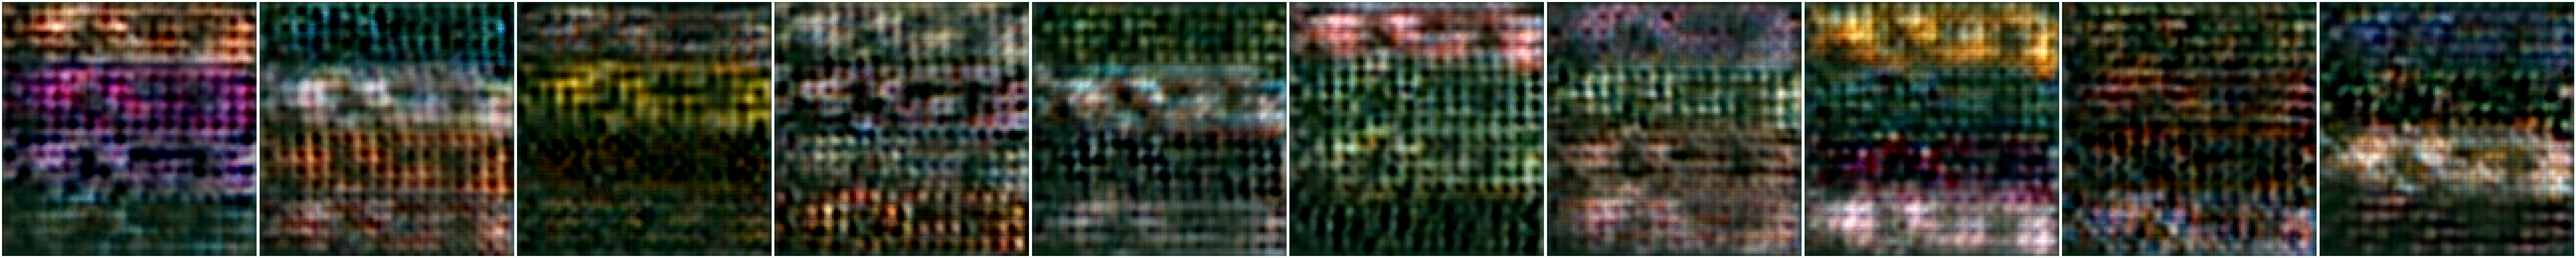

In [34]:
fig, axes = plt.subplots(1, 10, figsize=(128, 128))  # Adjust figsize as needed

for i in range(10):
    img = recons[i].numpy().reshape(3, 128, 128).transpose(1, 2, 0)
    axes[i].imshow(img)
    axes[i].axis('off')  # Turn off axis labels for clarity

plt.tight_layout()
plt.show()

## Frechet Inception Distance: VQVAE

In [ ]:
from torchmetrics.image.fid import FrechetInceptionDistance
fid = FrechetInceptionDistance(feature=64, normalize = True)
# Torchmetrics implementation does not use cuda for some reason
device = 'cpu'
vqvae = vqvae.to(device)

test_dataset = torchvision.datasets.CelebA(root='./data', split='test',
                                       download=True, transform=transform)

testloader = torch.utils.data.DataLoader(test_dataset, batch_size = 64)

progress_bar = tqdm(enumerate(testloader), total=len(testloader))
for i, (test_data, _) in progress_bar:
    test_data = test_data.to(device)
    selected_rows = choose_rows_uniformly(your_matrix, num_rows_to_choose)
    z = selected_rows.reshape(64, 64, 16, 16).to(device)
    sample = vqvae.decoder(z)
    fid.update(sample, real=False)
    fid.update(test_data, real=True)
fid.compute()